In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np

# Simple linear regression
Linear regression with only a slope, also known as simple linear regression, is a statistical technique used to model the relationship between a dependent variable and an independent variable when the relationship can be approximated by a straight line. In this case, we are considering a linear regression model with a single predictor variable and no intercept term.

To perform linear regression with only a slope, we need a set of paired observations (x, y), where x represents the independent variable (predictor) and y represents the dependent variable (response). The goal is to estimate the slope of the line that best fits the data points.

The formula for the simple linear regression model is:

$$y = \beta \cdot x + \epsilon$$

where:
- y is the dependent variable
- x is the independent variable
- β is the slope of the line
- ε is the error term representing the random variation or noise in the data

## Generate data

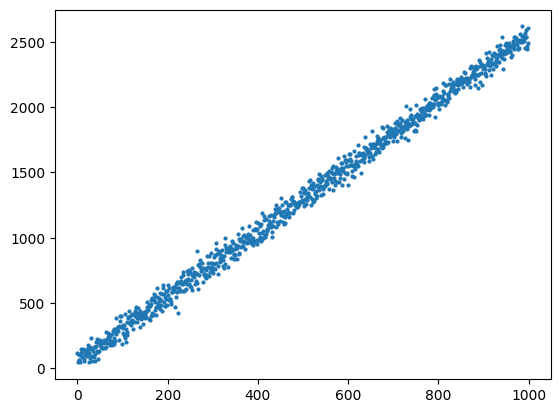

In [3]:
# Let us create some random data
size= 1000
mu, sigma = 50, 50 # mean and standard deviation
error=np.random.normal(mu, sigma, size)
x1 = np.arange(0, size)
y = 2.5*x1 + error
plt.plot(x1, y, 'o', markersize=2)
plt.show()

In [4]:
myRDD = sc.parallelize(zip(y,x1))
myRDD.take(5)

[(117.76858359936048, 0),
 (48.40901356949815, 1),
 (111.22653612053142, 2),
 (62.49655968876038, 3),
 (65.791700524905, 4)]

## Calculating the slope using sklearn. 
The fit() method returns an instance of the LinearRegression class, which contains the slope of the line in its coef_ attribute.

In [5]:
from sklearn.linear_model import LinearRegression

X = np.stack([x1], axis=1)
reg = LinearRegression(fit_intercept=False).fit(X, y)
print(reg.coef_)

[2.58105351]


## Calculating the slope using linear algebra.
Calculate the coefficients of a linear regression model using the normal equation approach

$$
\hat{\beta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y
$$

Where:
- $\hat{\beta}$ represents the estimated coefficients of the linear regression model.
- $X$ is the matrix of input variables.
- $X^T$ denotes the transpose of $X$.
- $y$ is the vector of dependent variable values.
- $(X^T \cdot X)^{-1}$ represents the inverse of the matrix product $X^T \cdot X$.

In [6]:
# Let use solve this also with the exact linear algebra solution. 
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(beta_hat)

[2.58105351]


## Calculating the slope using gradient descent
Gradient descent is an iterative optimization algorithm used to find the minimum value of a function. In the context of machine learning, we can use gradient descent to find the optimal values of the coefficients in a parameterized model.

1. Calculation of the prediction with current regression coefficients:
   - Prediction: $y_{\text{prediction}} = m_{\text{current}} \cdot x_1$

2. Computation of the cost (for monitoring purposes):
   - Cost: $cost = \frac{-1}{2n} \sum (y - y_{\text{prediction}})^2$

3. Calculation of the gradient:

$$
\begin{align*}
m_{\text{gradient}} & = \frac{\partial }{\partial m} \left(\frac{-1}{2n} \sum (y - mx)^2 \right) \\
& = \frac{-1}{2n}\sum \frac{\partial }{\partial m} (y - mx)^2 \\
& = \frac{-1}{2n}\sum 2(y - mx)(-x) \\
& = \frac{-1}{n} \sum x(y - mx) \\
\end{align*}
$$

   The final formula for gradient is: $m_{\text{gradient}} = \frac{-1}{n} \sum (x \cdot (y - mx))$

4. Update of the regression coefficient:
   - Updated coefficient: $m_{\text{current}} = m_{\text{current}} - \text{learningRate} \cdot m_{\text{gradient}}$

Here, the variable $n$ represents the number of data points in the dataset, $y$ is the dependent variable, $x_1$ is the independent variable, $m_{\text{current}}$ is the current value of the coefficient, and $\text{learningRate}$ is the learning rate (step size) used in the gradient descent algorithm.

In [7]:
# Now, we do gradient descent here with a very simple numpy array 
learningRate = 0.000001
num_iteration = 30 
m_current=0
n = float(size)

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    y_prediction = m_current * x1 
    # We compute costs just for monitoring 
    cost= sum (( y - y_prediction)**2)/size
    # calculate gradients. 
    m_gradient = (-1/n) * sum (x1 * (y - y_prediction) )
    print(i , "m=", m_current, " Cost=", cost)
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient 

0 m= 0  Cost= 2220612.47779051
1 m= 0.859061072190671  Cost= 990267.0649029795
2 m= 1.4321978410103677  Cost= 442626.61715091387
3 m= 1.8145754930851146  Cost= 198865.75384162928
4 m= 2.0696850528980404  Cost= 90365.07839811509
5 m= 2.239885605034971  Cost= 42070.219199319
6 m= 2.353437711702235  Cost= 20573.639426912192
7 m= 2.42919587327506  Cost= 11005.272325782513
8 m= 2.479739180778036  Cost= 6746.2855496861575
9 m= 2.51345998234322  Cost= 4850.563095974909
10 m= 2.535957371500659  Cost= 4006.7559159021557
11 m= 2.550966875883965  Cost= 3631.167941117957
12 m= 2.56098071439011  Cost= 3463.9895499713916
13 m= 2.56766161197782  Cost= 3389.576585918387
14 m= 2.572118883038271  Cost= 3356.454546753052
15 m= 2.5750926249712234  Cost= 3341.7115581833714
16 m= 2.5770766059685344  Cost= 3335.1492897529474
17 m= 2.5784002516265767  Cost= 3332.2283509792883
18 m= 2.5792833436674933  Cost= 3330.9282085955997
19 m= 2.5798725130936093  Cost= 3330.349500738694
20 m= 2.5802655871975384  Cost= 33

## Calculating the slope using gradient descent in PySpark
- `myRDD` contains tuples $(y,x)$ with the dependent variable $y$ as the first element `t[0]` and the independent variable $x$ as the second element `t[1]`. 
- `size` represents the size of the RDD
- `learningRate` represents the learning rate (step size) used in the gradient descent algorithm.
- `beta` represents the current value of the coefficient.
- `gradient` represents the gradient of the cost function.
- `cost` represents the cost of the current loss function.

The formula for the gradient calculation is: 

 $m_{\text{gradient}} = \frac{-1}{n} \sum (x \cdot (y - mx))$

In [9]:
# Now we do gradient Decent on our RDD data set. 
learningRate = 0.000001
num_iteration = 30 

m = 0
myRDD.cache()

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    
    gradientCost=myRDD.map(lambda t: (t[1], (t[0] - t[1] * m) ))\
                        .map(lambda t: (t[0]*t[1], t[1]**2 ))\
                        .reduce(lambda t, y: (t[0] +y[0], t[1]+y[1] ))
    cost= gradientCost[1]/(size)
    gradient=(-1.0/float(size))* gradientCost[0]
    print(i, "m", m, " Cost", cost)
    m = m - learningRate * gradient    

0 Beta 0  Cost 2214411.3361364314
1 Beta 0.8578738081033067  Cost 987464.3673429145
2 Beta 1.4302184740972617  Cost 441336.60491141886
3 Beta 1.8120676617021174  Cost 198249.05468770157
4 Beta 2.0668246477242924  Cost 90048.07839842068
5 Beta 2.2367899744392554  Cost 41886.61863143972
6 Beta 2.350185146585034  Cost 20449.41643203297
7 Beta 2.4258386067024307  Cost 10907.478950035924
8 Beta 2.4763120609018436  Cost 6660.256291807692
9 Beta 2.5099862586829764  Cost 4769.770177996769
10 Beta 2.5324525553569224  Cost 3928.2937511397918
11 Beta 2.5474413158768408  Cost 3553.7432205735518
12 Beta 2.557441314772253  Cost 3387.0266074041915
13 Beta 2.564112979035309  Cost 3312.8191858724526
14 Beta 2.568564089930867  Cost 3279.7886359728227
15 Beta 2.5715337220081684  Cost 3265.086370294377
16 Beta 2.5735149610474695  Cost 3258.5422280764483
17 Beta 2.574836777362983  Cost 3255.629357481862
18 Beta 2.575718648927847  Cost 3254.332806334561
19 Beta 2.576307004093227  Cost 3253.7556969769757
20 